# Interaction with the World Homework (#3)
Python Computing for Data Science (c) J Bloom, UC Berkeley, 2016

# 1) Monty: The Python Siri

Let's make a Siri-like program with the following properties:
   - record your voice command
   - use a webservice to parse that sound file into text
   - based on what the text, take three different types of actions:
       - send an email to yourself
       - do some math
       - tell a joke

So for example, if you say "Monty: email me with subject hello and body goodbye", it will email you with the appropriate subject and body. If you say "Monty: tell me a joke" then it will go to the web and find a joke and print it for you. If you say, "Monty: calculate two times three" it should response with printing the number 6.

Hint: you can use speed-to-text apps like Houndify to return the text (but not do the actions). You'll need to sign up for a free API and then follow documentation instructions for using the service within Python. 

In [135]:
import pyaudio

In [139]:
!ls

README.md            hw3_sound_files.zip  sample_wave.py
ThinkDSP             new_file.ogg         scipy2015_demo.ipynb
__pycache__          pySHSpeex            sound.py
homework.ipynb       sample_stdin.py      sound_files
houndify.py          sample_text.py       test_audio


In [152]:
chunk = 1024
FORMAT = pyaudio.paInt32
CHANNELS = 1
RATE = 44100
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "input-siri.wav"
p = pyaudio.PyAudio()
stream = p.open(format = FORMAT,
    channels = CHANNELS,
    rate = RATE,
    input = True,
    frames_per_buffer = chunk)
all = []
for i in range(0, int(RATE / chunk * RECORD_SECONDS)):
    data = stream.read(chunk)
    all.append(data)
print("* done recording")
stream.close()
p.terminate()

* done recording


In [162]:
p.get_sample_size(FORMAT)

4

In [164]:
import wave
data = b"".join(all)
wf = wave.open(WAVE_OUTPUT_FILENAME, "wb")
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(data)
wf.close()

In [155]:
!open input-siri.wav

In [140]:
import houndify

In [159]:
!ls

README.md            input-siri.wav       sample_text.py
ThinkDSP             klikey               sample_wave.py
__pycache__          klikey.py            scipy2015_demo.ipynb
homework.ipynb       new_file.ogg         sound.py
houndify.py          pySHSpeex            sound_files
hw3_sound_files.zip  sample_stdin.py      test_audio


In [145]:
import klikey

'otFb2p_hQKvEQkHSTXJurQ=='

In [150]:
userId = "test_user"
client = houndify.StreamingHoundClient(klikey.clientId, klikey.clientKey, userId, sampleRate=8000)

In [149]:
class MyListener(houndify.HoundListener):
  def onPartialTranscript(self, transcript):
    print("Partial transcript: " + transcript)
  def onFinalResponse(self, response):
    print("Final response: " + str(response))
  def onError(self, err):
    print("ERROR")


In [151]:
samples = 
client.start(MyListener())
#samples is the list of mono 16-bit little-endian PCM samples
client.fill(samples)
client.finish()


NameError: name 'samples' is not defined

Final response: {'ErrorMessage': 'Could not create speech handler because audio is not supported.', 'FormatVersion': '1.0', 'BuildInfo': {'User': 'knightly', 'Kind': 'Low Fat', 'Machine': 's10766724502414.pnp.melodis.com', 'BuildNumber': '3402', 'Date': 'Thu Sep 15 10:25:57 PDT 2016', 'SVNRevision': '30999', 'Variant': 'release', 'SVNBranch': 'dev_multi_machine'}, 'DomainUsage': [], 'ServerGeneratedId': 'f08ea9a6-2920-496c-af61-42fdb8dc5053', 'Format': 'SoundHoundVoiceSearchResult', 'Status': 'Error'}


In [137]:
chunk = 1024
FORMAT = pyaudio.paInt32
CHANNELS = 1
RATE = 44100
RECORD_SECONDS = 5

In [138]:
int(RATE / chunk * RECORD_SECONDS)

215

In [158]:
!./sample_wave.py $klikey.clientId $klikey.clientKey test_audio/whattimeisitindenver.wav 

============== test_audio/whattimeisitindenver.wav ===================
Partial transcript: 
Partial transcript: 
Partial transcript: 
Partial transcript: 
Partial transcript: 
Partial transcript: what
Partial transcript: what time
Partial transcript: what time
Partial transcript: what time is
Partial transcript: what time is it
Partial transcript: what time is it
Partial transcript: what time is it in
Partial transcript: what time is it and
Partial transcript: what time is it in then
Partial transcript: what time is it in denver
Partial transcript: what time is it in denver
Partial transcript: what time is it in denver
Partial transcript: what time is it in denver
Partial transcript: what time is it in denver
Partial transcript: what time is it in denver
Partial transcript: what time is it in denver
Partial transcript: what time is it in denver
Partial transcript: what time is it in denver
Partial transcript: what time is it in denver
Partial transcript: what time is it in denver
Final

In [ ]:
input-siri.wav

In [161]:
Wave_read.getsampwidth(input-siri.wav)

NameError: name 'Wave_read' is not defined

In [160]:
!./sample_wave.py $klikey.clientId $klikey.clientKey input-siri.wav

============== input-siri.wav ===================
input-siri.wav: wrong sample width (must be 16-bit)


# 2) Write a program that identifies musical notes from sound (AIFF) files. 

  - Run it on the supplied sound files (12) and report your program’s results. 
  - Use the labeled sounds (4) to make sure it works correctly. The provided sound files contain 1-3 simultaneous notes from different organs.
  - Save copies of any example plots to illustrate how your program works.
  
  https://piazza.com/berkeley/fall2016/ay250/resources -> hw3_sound_files.zip

Hints: You’ll want to decompose the sound into a frequency power spectrum. Use a Fast Fourier Transform. Be care about “unpacking” the string hexcode into python data structures. The sound files use 32 bit data. Play around with what happens when you convert the string data to other integer sizes, or signed vs unsigned integers. Also, beware of harmonics.

In [33]:
!ls

ThinkDSP             hw3_sound_files.zip  sound.py
__pycache__          new_file.ogg         sound_files
homework.ipynb       scipy2015_demo.ipynb


In [40]:
import pyaudio
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import os

In [37]:
import soundfile as sf 

In [42]:
sound_files = sorted([os.path.join("sound_files", x) \
                      for x in os.listdir("sound_files")])
sound_files

['sound_files/.DS_Store',
 'sound_files/1.aif',
 'sound_files/10.aif',
 'sound_files/11.aif',
 'sound_files/12.aif',
 'sound_files/2.aif',
 'sound_files/3.aif',
 'sound_files/4.aif',
 'sound_files/5.aif',
 'sound_files/6.aif',
 'sound_files/7.aif',
 'sound_files/8.aif',
 'sound_files/9.aif',
 'sound_files/A4_PopOrgan.aif',
 'sound_files/C4+A4_PopOrgan.aif',
 'sound_files/F3_PopOrgan.aif',
 'sound_files/F4_CathedralOrgan.aif']

In [72]:
def load(filename):
    """Load an audio file and average over channels. Returns the data as a
    numpy array and the sampling rate.

    """
    (data, rate) = sf.read(filename)
    if data.ndim == 2:
        data = np.mean(data, axis=-1)
    rate = fh.samplerate
    return data, rate


In [227]:
filename = sound_files[15]; filename

'sound_files/F3_PopOrgan.aif'

In [228]:
(data, rate) = sf.read(filename)
data.shape

(705600, 2)

In [229]:
data.shape

(705600, 2)

In [230]:
if data.shape[1] == 2:
        data = np.mean(data, axis=-1)
data

array([  3.05175781e-05,   3.05175781e-05,   2.74658203e-04, ...,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])

In [231]:
rate

44100

In [232]:
def plot_amplitude(data, rate):
    time = arange(data.size) 
    print(time.shape)
    time = time/float(rate)
    fig = plt.figure(figsize=(7, 4.5))
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.plot(time, data, color="red", linestyle="-")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Amplitude")
    ax1.set_xlim(min(time), max(time))

In [233]:
data.shape

(705600,)

In [234]:
time = arange(data.size) 
print(time.shape)

(705600,)


(705600,)


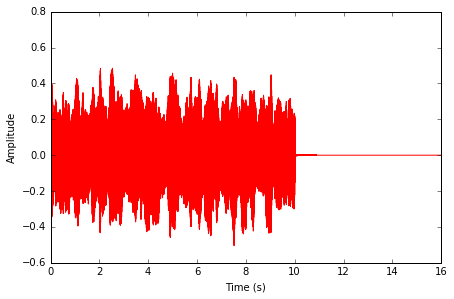

In [235]:
plot_amplitude(data, rate)

In [236]:
def freq_power(data, rate):
    """Compute the frequency and power spectrum of an audio signal."""
    n = 10000
    fft = np.fft.fft(data, n)[1:n/2]
    power = np.abs(fft) ** 2
    freq = rate * np.fft.fftfreq(n)[1:n/2]

    return freq, power


In [237]:
def plot_power(freq, power):
    """Plot frequency vs. power of an audio signal."""
    plt.loglog(freq, power, basex=2, basey=2, color='r')
    plt.xlabel("Frequency")
    plt.ylabel("Power")

    fig = plt.gcf()
    fig.set_figwidth(10)
    fig.set_figheight(7)


/Users/kevinli/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/kevinli/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


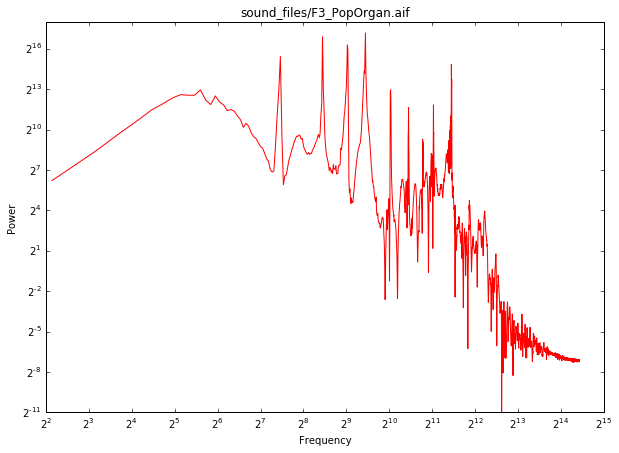

In [238]:
# plot frequency vs. power
freq, power = freq_power(data, rate)
plot_power(freq, power)
plt.title(filename)

In [239]:
NOTES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

In [242]:
import seaborn 

def bin_notes(freq, power):
    """From the frequency and power spectrum of an audio signal, compute
    bins corresponding to musical notes. Each bin is the mean of the
    power spectrum for the corresponding note. Returns the log
    frequencies, note labels, and averaged power.

    """
    scale = ["%s%d" % (x, i) for i in range(9) for x in NOTES]
    scale = ["B-1"] + scale

    # B-1 to C8
    B_1 = 30.87 / 2
    C8 = 4186.01
    bins = np.logspace(np.log2(B_1), np.log2(C8), 8*12 + 2, base=2)

    scale, bins = zip(*zip(scale, bins))
    bins = np.array(bins)

    # halfway between B-1 and C0 to halfway between B8 and C8
    mids = (bins[:-1] + bins[1:]) / 2.
    lower = mids[:-1]
    upper = mids[1:]

    binned = np.empty(lower.size) * np.nan
    for i, (l, u) in enumerate(zip(lower, upper)):
        idx = (freq >= l) & (freq < u)
        binned[i] = np.mean(power[idx])

    X = np.log2(bins[1:-1])
    Xt = scale[1:-1]
    Y = binned

    return X, Xt, Y

/Users/kevinli/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/kevinli/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:94: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/kevinli/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:106: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Notes:  F


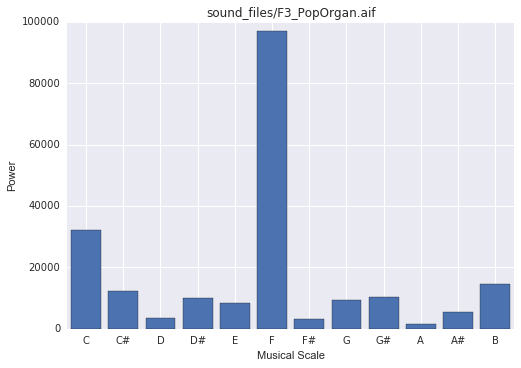

In [243]:
bins, notes, Y = bin_notes(freq, power)
plot_notes(bins, Y)
plt.title(filename)
print("Notes: ", " ".join(pick_notes(Y)))